In this notebook, we will demonstrate how to use _Tunax_ to calibrate the parameters of the $k-\varepsilon$ closure model. Our approach utilizes a _perfect-model_ framework, based on the idealized Kato-Phillips [1] case. This case is characterized by the absence of heat flux and the presence of uniform zonal wind forcing.

In a _perfect-model_ framework, the “observations” used for calibration are actually outputs from a model run, generated using a specific set of $k-\varepsilon$ parameters. The goal is for _Tunax_ to successfully retrieve these original parameters through the calibration process.

In [1]:
## General importations
import os
import jax.numpy as jnp

# add the source folder to import the Tunax modules
os.chdir('../src')

# Single column model run to create the database
First, we will run the single column model that goes with _Tunax_, with the $k-\varepsilon$ closure with some initial parameters and on the Kato-Phillips case to create our database of "observations".

### Grid
First we have to define the vertical grid on which we will work. We use the class `Grid` and the class method `linear` to create a regular grid with 100 points on a depth of 50 meters. This object contains in part the vector of the depths of the centers of the cells `zr` and the vector of the vector of the interfaces `zw`.

In [2]:
from grid import Grid
grid = Grid.linear(100, 50)

### Initial state
The initial state for the Kato-Phillips idealized case is defind by zero velocities, a fully stratified temperature and a constant salinity. The class `State` represent the state of the water column at one time, which means the tempetature, the salinity and the horizontal velocities. This object also contains the variables linked to the turbulence used in the integration of the model, like the eddy-diffusivity àkv`for example. Each one defined on the specific vertical grid that we defined. To built our initial state we follow these steps
1. we initialize a `State` object defined on our `grid`, every variable is set to 0
2. we initialize all the variables to the default values with the method `init_all`
3. we reinitialize the temparature and the salinity to our specific case with `init_t` and `init_s` (note that we use the default slope of the stratification for the temperature)

In [3]:
from model import State
state0 = State(grid)
state0 = state0.init_all()
state0 = state0.init_t(hmxl=0., t_sfc=16.)
state0 = state0.init_s(hmxl=100)

### Kato-Phillips physical case
Here we will initialize the physical case of our Kato-Phillips experiments, which as we said correspond to no heat flux and a constant zonal wind of $0.01 \text m \cdot \text s ^{-1}$. The class `Case` contains all the physical parameters for a run of the model, like the latitude of the water column `lat` or the wind velocity `u_wind` when it's constant for example. The parameters that we don't modified are already the default values on the Kato-Phillips case.

In [4]:
from case import Case
case = Case(lat=0., tflx_sfc_W=0., u_wind=1e-2)
case

Case(
  rho0=1024.0,
  grav=9.81,
  cp=3985.0,
  alpha=0.0002,
  beta=0.0002,
  t_ref=2.0,
  s_ref=35.0,
  fcor=f32[],
  ustr_sfc=0.0001,
  ustr_btm=0.0,
  vstr_sfc=0.0,
  vstr_btm=0.0,
  tflx_sfc=0.0,
  tflx_btm=0.0,
  sflx_sfc=0.0,
  sflx_btm=0.0,
  rflx_sfc_max=0.0,
  do_diurnal_cycle=False
)

### Initialization of the model
Now that we have a initial condition, a grid and a physical case, we can defined the model instance with the class `SingleColumnModel`. For that we need to add the number of time steps that we need `nt`, the duration of one time step `dt` the time step between 2 steps of the output `out_dt`, and last but not least, the name of the closure that we will use, here it's `'k-epsilon'`. Here we do a simulation of $30 \text h$.

In [5]:
from model import SingleColumnModel
nt = 3600
dt = 300.
out_dt = 300.
model = SingleColumnModel(nt, dt, out_dt, grid, state0, case, 'k-epsilon')

### Closure parameters
The $k-\varepsilon$ closure is included in the _Tunax_ sources. One can find it in `src/closures/k_eppsilon.py`. I will come back on the abstract way to define a closure for _Tunax_, here we will just initialize the parameters of $k-\varepsilon$ with their default values. For that we need to use the `CLOSURES_REGISTRY` which contains all the closures defined as abstract closures. For each one, the attribute `parameters_class` is a class that allows us to manipulate the parameters of a closure.

In [6]:
from closures_registry import CLOSURES_REGISTRY
KepsParamsClass = CLOSURES_REGISTRY['k-epsilon'].parameters_class
keps_default_params = KepsParamsClass()
keps_default_params

KepsParameters(
  a1=0.26666666666999994,
  a2=0.016000000000000014,
  a3=0.43200000000000005,
  nn=2.5,
  sf_d0=19913.90625,
  sf_d1=5087.266065,
  sf_d2=571.8541632000001,
  sf_d3=103.99548235898882,
  sf_d4=172.800648,
  sf_d5=-0.6715392000000003,
  sf_n0=2124.1500000265514,
  sf_n1=345.2849136057119,
  sf_n2=-2.40000000003,
  sf_nb0=2231.25,
  sf_nb1=90.0,
  sf_nb2=17.66630399938841,
  lim_am0=42300123.961466245,
  lim_am1=17682087.61118832,
  lim_am2=2123610.720196583,
  lim_am3=59665.45681569103,
  lim_am4=1214704.020776464,
  lim_am5=418354.61919118604,
  lim_am6=35908.07114170779
)

### Run the model
Now we can run our model with these default values of $k-\varepsilon$ parameters. The run don't modify the `model` instance (as long as we use _JAX_ which don't allow in place modification) but returns a object of the class `Trajectory`. This class is simply the set of the timeseries of the velocities and the tracers. It's like a _pandas_ dataframe but defined with _JAX_.

In [7]:
trajectory_obs = model.compute_trajectory_with(keps_default_params)
trajectory_obs

Trajectory(
  grid=Grid(nz=100, h=f32[], zr=f32[100], zw=f32[101], hz=f32[100]),
  time=f32[360],
  u=f32[360,100],
  v=f32[360,100],
  t=f32[360,100],
  s=f32[360,100]
)

The time dimension of these vectors is 360 because we asked the model for an output time step of $300 \text s$ during $30 \text h$. We can plot the initial and final states of this experience. And we can notice that only the temperature $T$ and the zonal velocity $u$ are mostly affected by the Kato-Phillips case.

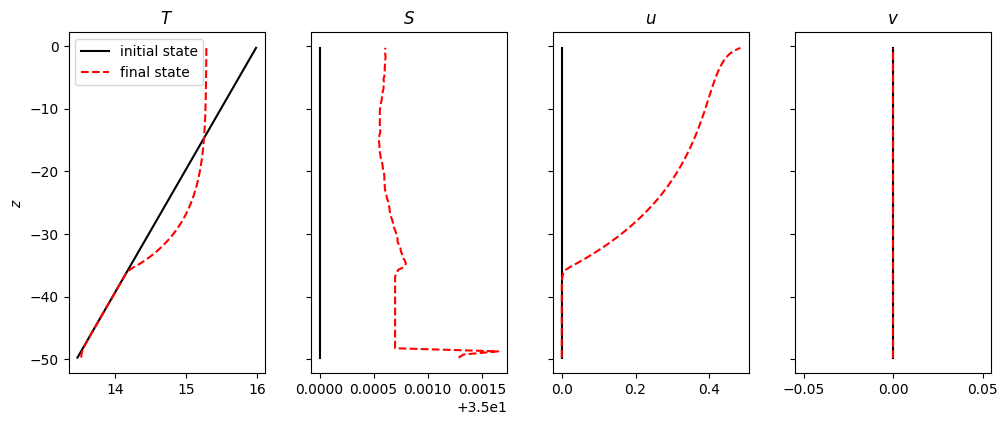

In [8]:
import matplotlib.pyplot as plt

zr = model.grid.zr

fig, [ax_t, ax_s, ax_u, ax_v] = plt.subplots(1, 4, sharey=True, figsize=(10, 4))
plt.tight_layout()

ax_t.plot(trajectory_obs.t[0, :], zr, 'k', label='initial state')
ax_t.plot(trajectory_obs.t[-1, :], zr, 'r--', label='final state')
ax_s.plot(trajectory_obs.s[0, :], zr, 'k')
ax_s.plot(trajectory_obs.s[360, :], zr, 'r--')
ax_u.plot(trajectory_obs.u[0, :], zr, 'k')
ax_u.plot(trajectory_obs.u[-1, :], zr, 'r--')
ax_v.plot(trajectory_obs.v[0, :], zr, 'k')
ax_v.plot(trajectory_obs.v[-1, :], zr, 'r--')

ax_t.set_title('$T$')
ax_s.set_title('$S$')
ax_u.set_title('$u$')
ax_v.set_title('$v$')

ax_t.set_ylabel('$z$')

ax_t.legend()

plt.show()

# Calibration parameters
Now that we have a timeseries to do our calibration, we can prepare this calibration.

### Observation database
First, we can transform our timeseries into an object which is understable by our salibration algorithm. Here we just convert the `Trajectory` object into a _pandas_ dataset and then into an `Obs` object to create a set of obervation `ObsSet`. These abstractions are not really needed here, but will be usefull when we will use a large set of observations to do the calibration.

In [9]:
from database import ObsSet, Obs
ds_obs = trajectory_obs.to_ds()
obs = Obs(ds_obs)
obs_set = ObsSet([obs])

### Parameters to calibrate
To define what parameters of our closure we are going to calibrate, we use the class `FittableParameter` which describes for one parameter if we fit it or not and the rules for the calibration in this case, and the class `FittableParametersSet` which represent the set of all the parameters of the closure and the way to calibrate them. Here we calibrate only the parameter $c_1$ of $k-\varepsilon$, the initial value during the calibration is 7 and it's bounded by 3 and 10. The other parameters are set to the default ones. The default value of $c_1$ used previously in the perfect model is 5, so we expect the value of 7 decrease to 5 during the calibration.

In [10]:
from fitter import FittableParameter, FittableParametersSet
c1_par = FittableParameter(True, min_bound=3., max_bound=10., init_val=7.)
coef_fit_params = FittableParametersSet({'c1': c1_par}, 'k-epsilon')

### Loss function
Then we have to define the loss function used in the calibration. This loss function must have the signature `Callable[[], Trajectory], ObsSet -> float` and the output should be positive. Here we take the suared $L_2$ norm of all the timeseries on the temperature. The abstract function `model` represent the run of the model with one set of parameters of the closure, at each iteration of the calibration, the loss function will be computed with a specific set of parameters. **à clarifier**.

In [11]:
def loss(model, obs_set):
    ds_obs = obs_set.observations[0].variables
    t_obs = jnp.array(ds_obs['t'])
    traj = model()
    return  jnp.sum((traj.t-t_obs)**2)

### Definition of the fitter
Adding some parametes for the calibration, we can define a "fitter" with the class `Fitter`. And call it to run the calibration.

In [12]:
from fitter import Fitter
nloop = 10
learning_rate = 1
verbatim = True
f = Fitter(coef_fit_params, nloop, model, obs_set, learning_rate, verbatim, loss)
clo_parf = f()


                    loop 0
                    x [6.0000067]
                    grads [10.557207]
                

                    loop 1
                    x [5.0160656]
                    grads [8.03836]
                

                    loop 2
                    x [4.24689]
                    grads [0.17956698]
                

                    loop 3
                    x [4.097928]
                    grads [-10.097944]
                


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103c02330>>
Traceback (most recent call last):
  File "/Users/admin-mouttaga/Codes/tunax/.venv_cpu/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:

                    loop 0
                    x [6.0000067]
                    grads [10.557207]
                

                    loop 1
                    x [5.0160656]
                    grads [8.03836]
                

                    loop 2
                    x [4.24689]
                    grads [0.17956698]
                

                    loop 3
                    x [4.097928]
                    grads [-10.097944]
                


# References
1. Kato H, Phillips OM. On the penetration of a turbulent layer into stratified fluid. Journal of Fluid Mechanics. 1969;37(4):643-655. doi:10.1017/S0022112069000784